In [1]:
import shutil                                                                                             
import pandas as pd
import numpy as np
import pretrainedmodels
import pretrainedmodels.utils as utils
import torch               
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable                            
from adversary.fgsm import Attack, where       
import adversary.cw as cw                      

device = 'cuda' if torch.cuda.is_available() else 'cpu'  

In [2]:
# Load Imagenet Synsets
with open('data/imagenet_synsets.txt', 'r') as f:
    synsets = f.readlines()

synsets = [x.strip() for x in synsets]
splits = [line.split(' ') for line in synsets]
key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}

with open('data/imagenet_classes.txt', 'r') as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

In [3]:
load_img = utils.LoadImage()
model = pretrainedmodels.__dict__['inceptionv4'](num_classes=1000, pretrained='imagenet').to(device)

In [4]:
tf_img = utils.TransformImage(model, scale=1,random_crop=False, random_hflip=False, random_vflip=False, preserve_aspect_ratio=True) 
checkpoint = torch.load('checkpoint/ImageNet_fast-Copy1.pth')
model.load_state_dict(checkpoint['net'])
model = model.to(device)
model.eval()

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, aff

In [22]:
# path_img = 'data/cbffc89d56ad58cb.png'
path_img = '/home/qifeiz/ImageNetData/mini-imagenet/images/n0185567200000068.jpg'
img_class = 301;
input_img = load_img(path_img)
input_tensor = tf_img(input_img)  

input_tensor = input_tensor.unsqueeze(0) # 3x299x299 -> 1x3x299x299
input_tensor = input_tensor.to(device)
target = torch.LongTensor([301]).to(device)

true class:  ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle
predicted class:  goose


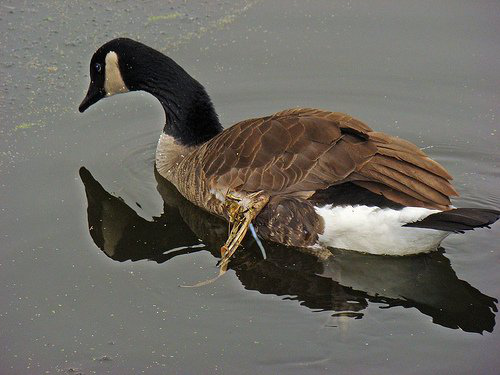

In [23]:
# benign example
output_logits = model(input_tensor) # 1x1000
class_id = torch.argmax(output_logits)

class_key = class_id_to_key[class_id]
classname = key_to_classname[class_key]
print('true class: ',key_to_classname[class_id_to_key[301]])
print('predicted class: ',classname)
input_img

In [14]:
EPSILON = 8 / 255 * (1 - -1)   
criterion_none = nn.CrossEntropyLoss(reduction='none') 
bim_attack = Attack(model, F.cross_entropy)   
def FGSM(x, y_true, eps=8 / 255, alpha=1 / 255, iteration=10, bim_a=False):                                            
    x = Variable(x.to(device), requires_grad=False)                                                                    
    y_true = Variable(y_true.to(device), requires_grad=False)                                                          
                                                                                                                       
    if iteration == 1:                                                                                                 
        x_adv = bim_attack.fgsm(x, y_true, False, eps, x_val_min=-1, x_val_max=1)                                      
    else:                                                                                                              
        if bim_a:                                                                                                      
            x_adv = bim_attack.i_fgsm_a(x, y_true, False, eps, alpha, iteration, x_val_min=-1, x_val_max=1)            
        else:                                                                                                          
            x_adv = bim_attack.i_fgsm(x, y_true, False, eps, alpha, iteration, x_val_min=-1, x_val_max=1)              
    return x_adv                                                                                                                                                                                                              

In [15]:
# benign undercover fgsm --> example1
benign_fgsm = FGSM(input_tensor, target, eps=EPSILON)                                
benign_fgsm_outputs = model(benign_fgsm)                                           
_, benign_fgsm_predicted = benign_fgsm_outputs.max(1)                            
temp1 = criterion_none(benign_fgsm_outputs, target).detach().cpu().numpy()
print('benign example criterion: ', temp1[0])

benign example criterion:  0.025501251


In [16]:
# crafted adversarial example
x_adv = FGSM(input_tensor, target, eps=EPSILON, alpha=2 / 255, iteration=20, bim_a=True)
adv_outputs = model(x_adv)                                        
_, adv_predicted = adv_outputs.max(1)
print('adv class: ', key_to_classname[class_id_to_key[adv_predicted]])

adv class:  leaf beetle, chrysomelid


In [17]:
# adv undercover fgsm
adv_fgsm = FGSM(x_adv, adv_predicted, eps=EPSILON)  #                           
adv_fgsm_outputs = model(adv_fgsm)                                                
_, adv_fgsm_predicted = adv_fgsm_outputs.max(1)                                 
temp2 = criterion_none(adv_fgsm_outputs, adv_predicted).detach().cpu().numpy()
print('adversarial example criterion: ', temp2[0])

adversarial example criterion:  4.843049
